In [90]:
%%capture
#Install AIF360
!pip install 'aif360[all]' matplotlib scikit-learn tensorflow numpy pandas

random_state = 1234567

In [91]:
%matplotlib inline
from matplotlib import pyplot as plt
from os import getenv
import os.path as path
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

In [92]:
plt.style.use('seaborn-v0_8-darkgrid')
if getenv('TEXLIVE_HOME') is not None:
    plt.style.use('tex')
    plt.rcParams['legend.fontsize'] = 10
    
colors = sns.color_palette(palette='tab10', n_colors=2)

# Adult dataset

## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [93]:
X, y, _ = fetch_adult()
X.head(10)

age         workclass     education  education-num  \
race      sex                                                          
Non-white Male     25           Private          11th              7   
White     Male     38           Private       HS-grad              9   
          Male     28         Local-gov    Assoc-acdm             12   
Non-white Male     44           Private  Some-college             10   
White     Male     34           Private          10th              6   
          Male     63  Self-emp-not-inc   Prof-school             15   
          Female   24           Private  Some-college             10   
          Male     55           Private       7th-8th              4   
          Male     65           Private       HS-grad              9   
          Male     36       Federal-gov     Bachelors             13   

                      marital-status         occupation   relationship   race  \
race      sex                                                                   
Non-white Male         Never-married  Machine-op-inspct      Own-child  Black   
White     Male    Married-civ-spouse    Farming-fishing        Husband  White   
          Male    Married-civ-spouse    Protective-serv        Husband  White   
Non-white Male    Married-civ-spouse  Machine-op-inspct        Husband  Black   
White     Male         Never-married      Other-service  Not-in-family  White   
          Male    Married-civ-spouse     Prof-specialty        Husband  White   
          Female       Never-married      Other-service      Unmarried  White   
          Male    Married-civ-spouse       Craft-repair        Husband  White   
          Male    Married-civ-spouse  Machine-op-inspct        Husband  White   
          Male    Married-civ-spouse       Adm-clerical        Husband  White   

                     sex  capital-gain  capital-loss  hours-per-week  \
race      sex                                                          
Non-white Male      Male             0             0              40   
White     Male      Male             0             0              50   
          Male      Male             0             0              40   
Non-white Male      Male          7688             0              40   
White     Male      Male             0             0              30   
          Male      Male          3103             0              32   
          Female  Female             0             0              40   
          Male      Male             0             0              10   
          Male      Male          6418             0              40   
          Male      Male             0             0              40   

                 native-country  
race      sex                    
Non-white Male    United-States  
White     Male    United-States  
          Male    United-States  
Non-white Male    United-States  
White     Male    United-States  
          Male    United-States  
          Female  United-States  
          Male    United-States  
          Male    United-States  
          Male    United-States

We can then map the protected attributes to integers,

In [94]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [95]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)

split the dataset,

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

and finally, one-hot encode the categorical features:

In [97]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse_output=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train.head(10)

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
1    1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                0.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                1.0   
     1                      0.0                  0.0                0.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race sex                                                       
1    1                       0.0                         1.0   
     0                       0.0                         1.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         1.0   
     0                       0.0                         0.0   
     1                       0.0                         1.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
race sex                                                               
1    1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   

          education_11th  education_12th  ...  native-country_Thailand  \
race sex                                  ...                            
1    1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               1.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
1    1                               0.0                           1.0   
     0                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           1

Note: the column names are lost in this transformation. The same encoding can be done with Pandas, but this cannot be combined with other preprocessing in a Pipeline.

In [98]:
pd.get_dummies(X).head(10)

age  education-num  capital-gain  capital-loss  hours-per-week  \
race sex                                                                   
0    1     25              7             0             0              40   
1    1     38              9             0             0              50   
     1     28             12             0             0              40   
0    1     44             10          7688             0              40   
1    1     34              6             0             0              30   
     1     63             15          3103             0              32   
     0     24             10             0             0              40   
     1     55              4             0             0              10   
     1     65              9          6418             0              40   
     1     36             13             0             0              40   

          workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
0    1                    False                False               True   
1    1                    False                False               True   
     1                    False                 True              False   
0    1                    False                False               True   
1    1                    False                False               True   
     1                    False                False              False   
     0                    False                False               True   
     1                    False                False               True   
     1                    False                False               True   
     1                     True                False              False   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  ...  \
race sex                                                      ...   
0    1                     False                       False  ...   
1    1                     False                       False  ...   
     1                     False                       False  ...   
0    1                     False                       False  ...   
1    1                     False                       False  ...   
     1                     False                        True  ...   
     0                     False                       False  ...   
     1                     False                       False  ...   
     1                     False                       False  ...   
     1                     False                       False  ...   

          native-country_Portugal  native-country_Puerto-Rico  \
race sex                                                        
0    1                      False                       False   
1    1                      False                       False   
     1                      False                       False   
0    1                      False                       False   
1    1                      False                       False   
     1                      False                       False   
     0                      False                       False   
     1                      False                       False   
     1                      False                       False   
     1                      False                       False   

          native-country_Scotland  native-country_South  \
race sex                                                  
0    1                      False                 False   
1    1                      False                 False   
     1                      False                 False   
0    1                      False                 False   
1    1                      False                 False   
     1                      False                 False   
     0                      False                 False   
     1                      False                 False

The protected attribute information is also replicated in the labels:

In [99]:
y_train.head(10)

race  sex
1     1      0
      0      1
      1      1
      1      0
      1      0
      1      0
      1      0
      1      0
      0      0
      1      0
Name: annual-income, dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [100]:
y_pred = LogisticRegression(solver='liblinear', random_state=random_state).fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8454337731259675

Now, we can analyze our predictions and quickly calculate the disparate impact for females vs. males:

In [101]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.2687836637388684

We can also calculate the disparate impact for a different attribute, race, comparing whites to non-whites: 

In [102]:
disparate_impact_ratio(y_test, y_pred, prot_attr='race')

0.5457741065389056

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [103]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.09884873540555517

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

If we wish to do something more complex, we can pass a custom array of protected attributes, like so (note: this choice of protected groups is just for demonstration):

In [104]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.3842555696519781

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [105]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'),
                     reweigher=Reweighing('sex'))

params = {'estimator__C': [1, 10]}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8402741947372301
{'estimator__C': 1}


In [106]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.5869536164535801

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [107]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=random_state)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.840569027788015

In [108]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.0674177070960344

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [109]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [110]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=random_state)
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=random_state)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.8200044224957618

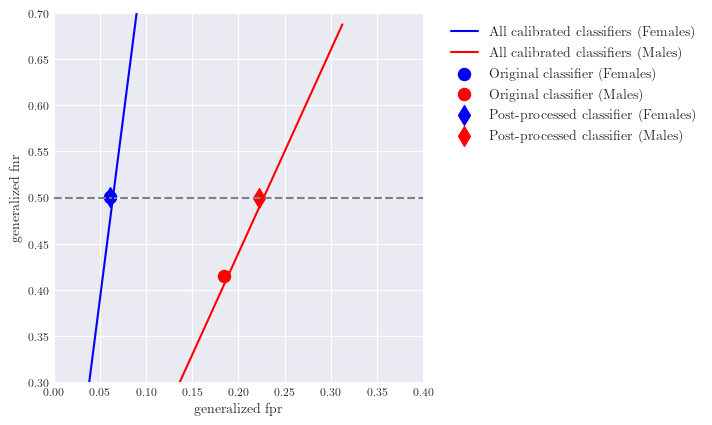

In [111]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1
    
plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='blue', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='red', marker='.', label='Original classifier (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='blue', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='red', marker='d', label='Post-processed classifier (Males)')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr')
plt.ylabel('generalized fnr')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.savefig(path.join(path.pardir, 'img', 'adult.png'), bbox_inches='tight')
plt.show()

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.

We can quanitify the discrepancy between protected groups using the `difference` operator:

In [112]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

0.0006948514904496772

# Bank marketing dataset

In [113]:
bank_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


bank_dtypes = {
    'age': 'int64',
    'job': 'category',
    'marital': 'category',
    'education': 'category',
    'default': 'category',
    'balance': 'int64',
    'housing': 'category',
    'loan': 'category',
    'contact': 'category',
    'day': 'int64',
    'month': 'category',
    'duration': 'int64',
    'campaign': 'int64',
    'pdays': 'int64',
    'previous': 'int64',
    'poutcome': 'category',
    'y': 'category'
}

bank_data = pd.read_csv(path.join(path.pardir, 'data', 'bank-marketing', 'bank.csv'), index_col=None, delimiter=';',   dtype=bank_dtypes, header=0, na_values='unknown', names=bank_names, skipinitialspace=True)

bank_data['education-binary'] = bank_data['education'].apply(lambda x: 'universitary' if x == 'tertiary' else 'non-universitary')
bank_data['marital-binary'] = bank_data['marital'].apply(lambda x: 'married' if x == 'married' else 'not-married')
bank_data.set_index(['marital-binary', 'education-binary'], inplace=True)
bank_data.rename_axis(index={'education-binary': 'education', 'marital-binary': 'marital'}, inplace=True)
bank_data.head(10)

age            job  marital  education default  \
marital     education                                                          
married     non-universitary   30     unemployed  married    primary      no   
            non-universitary   33       services  married  secondary      no   
not-married universitary       35     management   single   tertiary      no   
married     universitary       30     management  married   tertiary      no   
            non-universitary   59    blue-collar  married  secondary      no   
not-married universitary       35     management   single   tertiary      no   
married     universitary       36  self-employed  married   tertiary      no   
            non-universitary   39     technician  married  secondary      no   
            universitary       41   entrepreneur  married   tertiary      no   
            non-universitary   43       services  married    primary      no   

                              balance housing loan   contact  day month  \
marital     education                                                     
married     non-universitary     1787      no   no  cellular   19   oct   
            non-universitary     4789     yes  yes  cellular   11   may   
not-married universitary         1350     yes   no  cellular   16   apr   
married     universitary         1476     yes  yes       NaN    3   jun   
            non-universitary        0     yes   no       NaN    5   may   
not-married universitary          747      no   no  cellular   23   feb   
married     universitary          307     yes   no  cellular   14   may   
            non-universitary      147     yes   no  cellular    6   may   
            universitary          221     yes   no       NaN   14   may   
            non-universitary      -88     yes  yes  cellular   17   apr   

                              duration  campaign  pdays  previous poutcome   y  
marital     education                                                           
married     non-universitary        79         1     -1         0      NaN  no  
            non-universitary       220         1    339         4  failure  no  
not-married universitary           185         1    330         1  failure  no  
married     universitary           199         4     -1         0      NaN  no  
            non-universitary       226         1     -1         0      NaN  no  
not-married universitary           141         2    176         3  failure  no  
married     universitary           341         1    330         2    other  no  
            non-universitary       151         2     -1         0      NaN  no  
            universitary            57         2     -1         0      NaN  no  
            non-universitary       313         1    147         2  failure  no

In [114]:
X = bank_data.drop(columns='y')
y = bank_data['y']
X.head(10)

age            job  marital  education default  \
marital     education                                                          
married     non-universitary   30     unemployed  married    primary      no   
            non-universitary   33       services  married  secondary      no   
not-married universitary       35     management   single   tertiary      no   
married     universitary       30     management  married   tertiary      no   
            non-universitary   59    blue-collar  married  secondary      no   
not-married universitary       35     management   single   tertiary      no   
married     universitary       36  self-employed  married   tertiary      no   
            non-universitary   39     technician  married  secondary      no   
            universitary       41   entrepreneur  married   tertiary      no   
            non-universitary   43       services  married    primary      no   

                              balance housing loan   contact  day month  \
marital     education                                                     
married     non-universitary     1787      no   no  cellular   19   oct   
            non-universitary     4789     yes  yes  cellular   11   may   
not-married universitary         1350     yes   no  cellular   16   apr   
married     universitary         1476     yes  yes       NaN    3   jun   
            non-universitary        0     yes   no       NaN    5   may   
not-married universitary          747      no   no  cellular   23   feb   
married     universitary          307     yes   no  cellular   14   may   
            non-universitary      147     yes   no  cellular    6   may   
            universitary          221     yes   no       NaN   14   may   
            non-universitary      -88     yes  yes  cellular   17   apr   

                              duration  campaign  pdays  previous poutcome  
marital     education                                                       
married     non-universitary        79         1     -1         0      NaN  
            non-universitary       220         1    339         4  failure  
not-married universitary           185         1    330         1  failure  
married     universitary           199         4     -1         0      NaN  
            non-universitary       226         1     -1         0      NaN  
not-married universitary           141         2    176         3  failure  
married     universitary           341         1    330         2    other  
            non-universitary       151         2     -1         0      NaN  
            universitary            57         2     -1         0      NaN  
            non-universitary       313         1    147         2  failure

In [115]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [116]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

In [118]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse_output=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
X_train.head(10)

job_admin.  job_blue-collar  job_entrepreneur  \
marital education                                                  
1        0                0.0              1.0               0.0   
0        0                0.0              0.0               0.0   
         0                0.0              0.0               0.0   
1       -1                0.0              0.0               0.0   
0        1                0.0              0.0               0.0   
         1                0.0              0.0               0.0   
         0                0.0              0.0               0.0   
1        0                0.0              0.0               0.0   
0        0                0.0              1.0               0.0   
         0                1.0              0.0               0.0   

                   job_housemaid  job_management  job_retired  \
marital education                                               
1        0                   0.0             0.0          0.0   
0        0                   0.0             0.0          0.0   
         0                   0.0             0.0          0.0   
1       -1                   0.0             0.0          0.0   
0        1                   0.0             1.0          0.0   
         1                   0.0             0.0          0.0   
         0                   1.0             0.0          0.0   
1        0                   0.0             0.0          0.0   
0        0                   0.0             0.0          0.0   
         0                   0.0             0.0          0.0   

                   job_self-employed  job_services  job_student  \
marital education                                                 
1        0                       0.0           0.0          0.0   
0        0                       0.0           0.0          0.0   
         0                       0.0           0.0          0.0   
1       -1                       0.0           0.0          1.0   
0        1                       0.0           0.0          0.0   
         1                       0.0           0.0          0.0   
         0                       0.0           0.0          0.0   
1        0                       0.0           1.0          0.0   
0        0                       0.0           0.0          0.0   
         0                       0.0           0.0          0.0   

                   job_technician  ...  poutcome_other  poutcome_success  \
marital education                  ...                                     
1        0                    0.0  ...             0.0               0.0   
0        0                    1.0  ...             0.0               0.0   
         0                    1.0  ...             0.0               0.0   
1       -1                    0.0  ...             0.0               0.0   
0        1                    0.0  ...             0.0               0.0   
         1                    1.0  ...             0.0               0.0   
         0                    0.0  ...             0.0               0.0   
1        0                    0.0  ...             0.0               0.0   
0        0                    0.0  ...             0.0               0.0   
         0                    0.0  ...             0.0               0.0   

                   poutcome_nan   age  balance   day  duration  campaign  \
marital education                                                          
1        0                  1.0  38.0     -1.0   7.0      72.0       1.0   
0        0                  1.0  53.0   6839.0  19.0      77.0       1.0   
         0                  1.0  41.0    288.0  15.0     221.0       4.0   
1       -1                  1.0  22.0    549.0   2.0     154.0       1.0   
0        1                  1.0  37.0   5355.0  17.0     466.0       4.0   
         1                  1.0  31.0    636.0   4.0     352.0       4.0   
         0                  1.0  58.0   5278.0   4.0     763.0       4.0   
1        0         

In [119]:
pd.get_dummies(X).head(10)

age  balance  day  duration  campaign  pdays  previous  \
marital education                                                           
0       0           30     1787   19        79         1     -1         0   
        0           33     4789   11       220         1    339         4   
1       1           35     1350   16       185         1    330         1   
0       1           30     1476    3       199         4     -1         0   
        0           59        0    5       226         1     -1         0   
1       1           35      747   23       141         2    176         3   
0       1           36      307   14       341         1    330         2   
        0           39      147    6       151         2     -1         0   
        1           41      221   14        57         2     -1         0   
        0           43      -88   17       313         1    147         2   

                   job_admin.  job_blue-collar  job_entrepreneur  ...  \
marital education                                                 ...   
0       0               False            False             False  ...   
        0               False            False             False  ...   
1       1               False            False             False  ...   
0       1               False            False             False  ...   
        0               False             True             False  ...   
1       1               False            False             False  ...   
0       1               False            False             False  ...   
        0               False            False             False  ...   
        1               False            False              True  ...   
        0               False            False             False  ...   

                   month_jul  month_jun  month_mar  month_may  month_nov  \
marital education                                                          
0       0              False      False      False      False      False   
        0              False      False      False       True      False   
1       1              False      False      False      False      False   
0       1              False       True      False      False      False   
        0              False      False      False       True      False   
1       1              False      False      False      False      False   
0       1              False      False      False       True      False   
        0              False      False      False       True      False   
        1              False      False      False       True      False   
        0              False      False      False      False      False   

                   month_oct  month_sep  poutcome_failure  poutcome_other  \
marital education                                                           
0       0               True      False             False           False   
        0              False      False              True           False   
1       1              False      False              True           False   
0       1              False      False             False           False   
        0              False      False             False           False   
1       1              False      False              True           False   
0       1              False      False             False            True   
        0              False      False             False           False   
        1              False      False             False           False   
        0              False      False              True           False   

                   poutcome_success  
marital education                    
0       0                     False  
        0                     False  
1       1                     False  
0       1                     False  
        0                     False  
1       1                     False  
0       1                     False  
        0                     False  

In [120]:
y_train.head(10)

marital  education
1         0           0
0         0           0
          0           0
1        -1           0
0         1           1
          1           1
          0           0
1         0           0
0         0           0
          0           0
Name: y, dtype: int64

In [121]:
y_pred = LogisticRegression(solver='liblinear', random_state=random_state).fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8983050847457628

In [122]:
disparate_impact_ratio(y_test, y_pred, prot_attr='marital')

0.6334074636580603

In [123]:
disparate_impact_ratio(y_test, y_pred, prot_attr='education', priv_group=0)

0.7982355714189507

In [124]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.01204666321136405

In [125]:
marital = y_test.index.get_level_values('marital').to_numpy()
education = y_test.index.get_level_values('education').to_numpy()
prot_attr = np.where(marital ^ education, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.9474953740417658

In [126]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear', random_state=random_state),
                     reweigher=Reweighing('marital'))

params = {'estimator__C': [1, 10]}
clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8975681650700074
{'estimator__C': 10}


In [127]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='marital')

0.8098953552414172

In [128]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='education', priv_group=0)

0.8277998518418749

In [129]:
adv_deb = AdversarialDebiasing(prot_attr='marital', random_state=random_state)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.8820928518791452

In [130]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='marital')

0.018265798751258992

In [131]:
adv_deb.sess_.close()

In [132]:
cal_eq_odds = CalibratedEqualizedOdds('marital', cost_constraint='fnr', random_state=random_state)
log_reg = LogisticRegression(solver='liblinear', random_state=random_state)
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=random_state)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.8901989683124539

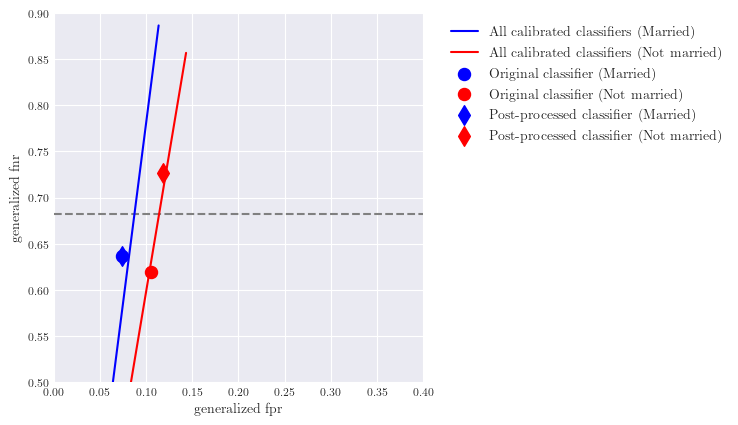

In [133]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('marital') == 1

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Married)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Not married)')
plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='blue', marker='.', label='Original classifier (Married)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='red', marker='.', label='Original classifier (Not married)')
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='blue', marker='d', label='Post-processed classifier (Married)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='red', marker='d', label='Post-processed classifier (Not married)')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.5, 0.9])
plt.xlabel('generalized fpr')
plt.ylabel('generalized fnr')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.savefig(path.join(path.pardir, 'img', 'bank-marketing.png'), bbox_inches='tight')
plt.show()

In [134]:
difference(generalized_fnr, y_test, y_pred, prot_attr='marital')

-0.0897221918058555